# CI width by changing sample size for QMC and IID Beta for the Hedged (Betting) CI Method

[This JRSSB article by Ian Waudby-Smith and Aaditya Ramdas](https://academic.oup.com/jrsssb/article/86/1/1/7043257) takes $X_1, X_2, \ldots \stackrel{\text{IID}}{\sim} F$ and computes a sequential confidence interval for $\mu = \mathbb{E}(X)$.

For Quasi-Monte Carlo (QMC), also know as low discrepancy sequences, we are going to take 

$$
X_i = \frac{1}{m} \sum_{j=1}^m T_{ij},
$$ 

where for each $i$, $\{T_{ij}\}_{j=1}^m$ is a QMC set that mimics $F$. Therefore, $X_i$ is close to $\mu$, and the sequence $\{X_i\}_{i=1}^n$ is an IID sequence based on $N = mn$ samples.

In this notebook, $F$ is a Beta Distribution and DigitalNetB2 (Sobol) has been used for QMC. We refer to $m$ as gen_samples and $n$ as spawn_samples.

Importing the necessary modules:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from scipy.stats import beta
from confseq.betting import betting_ci_seq
import qmcpy as qp

The parameters used for our numerical experiments

In [2]:
alpha = 0.05 # Significance level, confidence level = 1 - alpha
num_times = 100  #number of different times where CI will be computed
space_times = 1  
    #space between different times where CI will be computed for the IID_QMC_Beta samples. For IID_Beta, space between different times equals gen_samples * space_times
spawn_samples = num_times*space_times # The number of IID replications for low discrepancy or QMC samples (n)
gen_samples = 2**5 # The number of low discrepancy or QMC samples generated per replication (m)
N = spawn_samples * gen_samples # The maxmimum sample size (N = mn)
beta_param = np.array([10,30]) #parameters for the beta distribution

The plot function used for both the IID_Beta and IID_QMC_Beta experiments:

In [3]:
def plot_func(times,lower_bound,upper_bound, title):
    fig, axs = plt.subplots(1, 2)
    axs[0].plot(times,lower_bound, color = "red")
    axs[0].plot(times,upper_bound, color = "red")
    axs[0].axhline(y=0.25, color="blue", linestyle="--")
    axs[1].plot(times,upper_bound - lower_bound, color = "red")
    axs[0].set_xlabel("sample size N") 
    axs[0].set_ylabel("Confidence Interval")
    axs[1].set_xlabel("sample size N") 
    axs[1].set_ylabel("CI Width")
    fig.text(0.45,1,title)
    fig.tight_layout()

IID_Beta Numerical Experiments

In [4]:
times_iid = (space_times * np.arange(1,num_times+1)) * gen_samples # The times (sample sizes) for which we'll compute the lower and upper bounds on the confidence intervals
x_iid = np.random.beta(beta_param[0], beta_param[1], N) # The IID_Beta samples
lower_bound_iid,upper_bound_iid = betting_ci_seq(x_iid, times=times_iid, alpha=alpha, parallel=True, m_trunc=True, trunc_scale=3 / 4) 
    # Getting the sequential CI according to the code from the paper above


Using 11 cores


/opt/miniconda3/envs/bet_sim/lib/python3.8/site-packages/numpy/core/fromnumeric.py:57
/opt/miniconda3/envs/bet_sim/lib/python3.8/site-packages/numpy/core/fromnumeric.py:57
/opt/miniconda3/envs/bet_sim/lib/python3.8/site-packages/numpy/core/fromnumeric.py:57
/opt/miniconda3/envs/bet_sim/lib/python3.8/site-packages/numpy/core/fromnumeric.py:57
/opt/miniconda3/envs/bet_sim/lib/python3.8/site-packages/numpy/core/fromnumeric.py:57
/opt/miniconda3/envs/bet_sim/lib/python3.8/site-packages/numpy/core/fromnumeric.py:57
/opt/miniconda3/envs/bet_sim/lib/python3.8/site-packages/numpy/core/fromnumeric.py:57
/opt/miniconda3/envs/bet_sim/lib/python3.8/site-packages/numpy/core/fromnumeric.py:57
/opt/miniconda3/envs/bet_sim/lib/python3.8/site-packages/numpy/core/fromnumeric.py:57
/opt/miniconda3/envs/bet_sim/lib/python3.8/site-packages/numpy/core/fromnumeric.py:57
/opt/miniconda3/envs/bet_sim/lib/python3.8/site-packages/numpy/core/fromnumeric.py:57


IID_QMC_Beta Numerical Experiments

In [5]:
# The function to generate the IID_QMC_Beta samples
def gen_qmc_samples_iid(distribution = qp.SciPyWrapper(discrete_distrib=qp.DigitalNetB2(1,seed = 7),scipy_distribs=beta(a=beta_param[0], b = beta_param[1]))
                         , spawn_samples = 11 ,gen_samples = 2**8):
    spw = distribution
    spws = spw.spawn(spawn_samples)
    samples = spws[0].gen_samples(gen_samples).flatten()
    for i in range (len(spws)- 1):
        curr_samples = spws[i + 1].gen_samples(gen_samples).flatten()
        samples = np.vstack((samples,curr_samples))
    return np.mean(samples, axis = 1), samples.flatten()

times_qmc = space_times * np.arange(1,num_times+1) # The times (sample sizes) for which we'll compute the lower and upper bound values
x_qmc, beta_qmc = gen_qmc_samples_iid(spawn_samples=spawn_samples,gen_samples=gen_samples) # The IID_QMC_Beta samples
lower_bound_qmc,upper_bound_qmc = betting_ci_seq(x_qmc, times=times_qmc, alpha=alpha, parallel=True, m_trunc=True, trunc_scale=3 / 4) 
    # Getting the sequential CI according to the code from the paper above

Using 11 cores


Histograms and kernel density estimates of IID_Beta, QMC Transformed Beta Samples, and IID_QMC_Beta

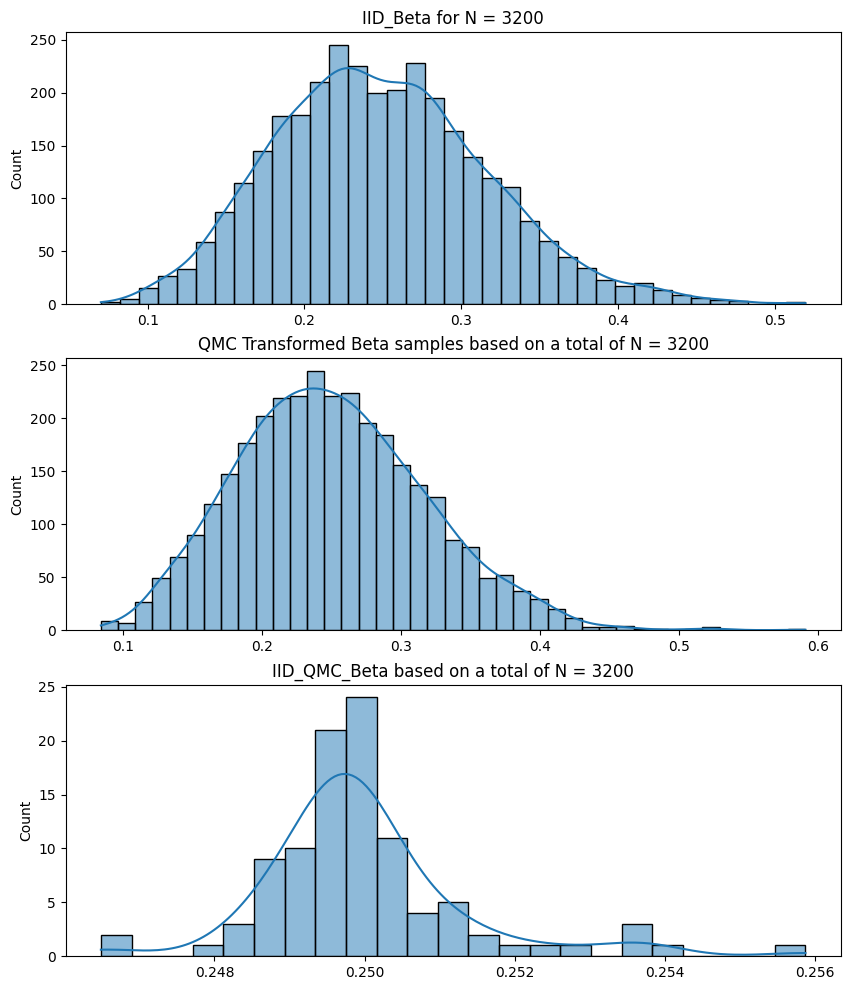

In [6]:
fig, axs = plt.subplots(3, 1, figsize=(10, 12))

sns.histplot(x_iid, kde= True, ax=axs[0], edgecolor='black') # IID_Beta Hist and KDE
axs[0].set_title(f'IID_Beta for N = {N}'); 

sns.histplot(beta_qmc, kde= True, ax=axs[1], edgecolor='black') # QMC Transformed Beta Samples Hist and KDE
axs[1].set_title(f'QMC Transformed Beta samples based on a total of N = {N}');

sns.histplot(x_qmc, kde= True, ax=axs[2], edgecolor='black') # IID_QMC_Beta Hist and KDE
axs[2].set_title(f'IID_QMC_Beta based on a total of N = {N}');

We note the following:
* The QMC Transformed Beta points (plot 2) make a smoother histogram than the IID_Beta points (plot 1).
* The $X_i$ from the IID_QMC_Beta points (plot 3) seem to have a heavy-tailed distribution.

## Simulation Plots

Here, we plot the confidence interval width as a function of sample size $N$ for IID_Beta and IID_QMC_Beta samples using the Hedged (Betting) CI method:

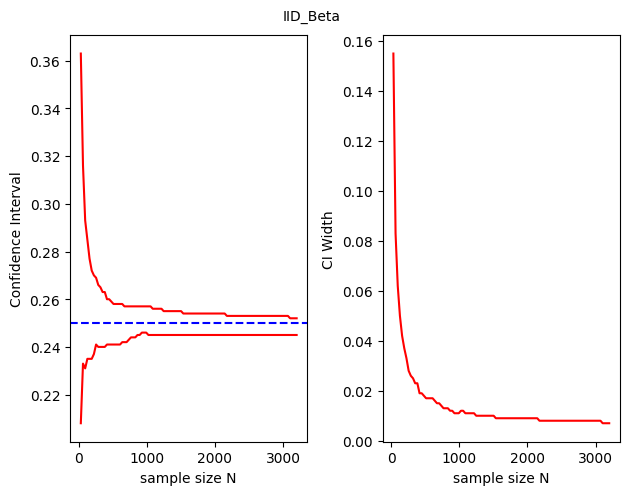

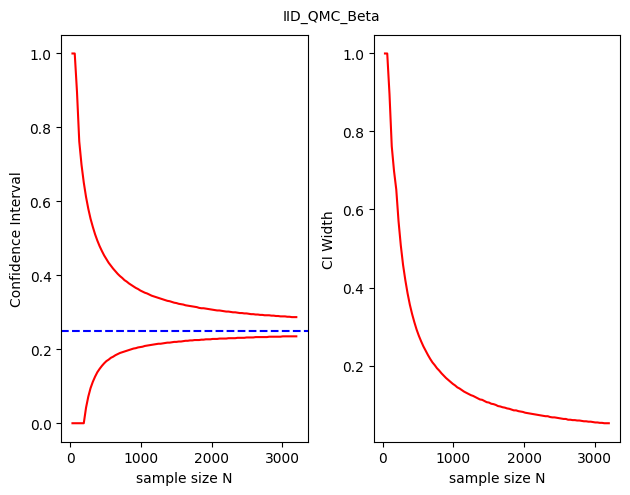

In [7]:
plot_func(times_iid,lower_bound_iid,upper_bound_iid,"IID_Beta") # IID_Beta Plot
plot_func(times_qmc * gen_samples,lower_bound_qmc,upper_bound_qmc,"IID_QMC_Beta") # IID_QMC_Beta Plot

## Printing the Simulation Output

Here, we print out the mean, std, upper bound, lower bound, Betting CI width, and CLT CI width for IID_Beta and IID_QMC_Beta based on a total of $N$ samples:


In [8]:
# Printing out the mean, std, upper bound, lower bound, Betting CI width, and CLT CI width for IID_Beta based on a total of N samples
print("IID_Beta mean for sample size N =", N, "is", x_iid.mean())
print("IID_Beta std for sample size N =", N, "is", x_iid.std())
print("IID_Beta Upper bound at sample size N =", N, "is", upper_bound_iid[len(upper_bound_iid) - 1])
print("IID_Beta Lower bound at sample size N =",N, "is", lower_bound_iid[len(lower_bound_iid) - 1])
print("IID_Beta Betting CI width at sample size N =",N, "is", upper_bound_iid[len(upper_bound_iid) - 1] - lower_bound_iid[len(lower_bound_iid) - 1])
print("The IID_Beta CLT CI width for sample size N =", N,"would be", norm.ppf(1 - alpha / 2) * x_iid.std() / np.sqrt(N))

print("")

# Printing out the mean, std, upper bound, lower bound, Betting CI width, and CLT CI width for IID_QMC_Beta based on a total of N samples
print("IID_QMC_Beta mean based on a total of N =", N, "is", x_qmc.mean())
print("IID_QMC_Beta std based on a total of N =", N, "is", x_qmc.std())
print("IID_QMC_Beta Upper bound based on a total of N =", N, "is", upper_bound_qmc[len(upper_bound_qmc) - 1])
print("IID_QMC_Beta Lower bound based on a total of N =", N, "is", lower_bound_qmc[len(lower_bound_qmc) - 1])
print("IID_QMC_Beta Betting CI width based on a total of N =", N, "is", upper_bound_qmc[len(upper_bound_qmc) - 1] - lower_bound_qmc[len(lower_bound_qmc) - 1])
print("The IID_QMC_Beta CLT CI width based on a total of N =", N,"would be", norm.ppf(1 - alpha / 2) * x_qmc.std() / np.sqrt(spawn_samples))

IID_Beta mean for sample size N = 3200 is 0.24907062770086433
IID_Beta std for sample size N = 3200 is 0.06772796953509753
IID_Beta Upper bound at sample size N = 3200 is 0.252
IID_Beta Lower bound at sample size N = 3200 is 0.245
IID_Beta Betting CI width at sample size N = 3200 is 0.007000000000000006
The IID_Beta CLT CI width for sample size N = 3200 would be 0.002346611299853253

IID_QMC_Beta mean based on a total of N = 3200 is 0.24999892301082444
IID_QMC_Beta std based on a total of N = 3200 is 0.0013547078658965011
IID_QMC_Beta Upper bound based on a total of N = 3200 is 0.28700000000000003
IID_QMC_Beta Lower bound based on a total of N = 3200 is 0.23500000000000001
IID_QMC_Beta Betting CI width based on a total of N = 3200 is 0.05200000000000002
The IID_QMC_Beta CLT CI width based on a total of N = 3200 would be 0.00026551786267302595


Some further observations and questions:
* In both the IID_Beta and IID_QMC_Beta cases, the CI computed by the Hedged (Betting) method is wider than that computed by a CLT. Is this to be expected?
* The CLT CI width for IID_QMC_Beta is less than IID_Beta.
* In the case of IID_QMC_Beta, the CI computed by the Hedged (Betting) method is orders of magnitude larger than the CLT CI width for IID_QMC_Beta and larger than the Hedged (Betting) CI width for IID_Beta. Why is this? Could the heavy tailed distribution of IID_Beta_QMC samples (plot 3 of the Histogram and KDE distribution) explain it?